In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
np.random.seed(151)

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
from chainer import Chain, Variable
import chainer.links as L
import chainer.functions as F
from chainer.optimizers import SGD
from chainer.datasets import TupleDataset
from chainer.iterators import SerialIterator
from chainer.training import StandardUpdater, Trainer
from chainer.training.extensions import PrintReport, LogReport, Evaluator

# Deep Learningドリル - Dropout編 -

この章では、Dropoutについて学びます。

まず、従来の深いニューラルネットワークの学習が難しいものであると言うことを体感して頂き、それを解決するための方法(Dropout)について学びます。

例題は今までと同じものです。さあ、始めましょう！！

## 例題（再掲）

あなたの務める会社では、スマートフォンを使った高齢者見守りアプリの開発を進めています。

スマートフォンには様々なセンサーが付いているため、これらの情報を使って、高齢者のより詳細な行動を取得するプロジェクトが開始されました。

センサーの情報から、「寝ている」「座った」「立ち上がった」「歩いた」「登った」「降った」の6カテゴリに分類するモデルを学習してください。

## 方針

今までは簡単なネットワークでしたが、今回はもっと深いネットワークに挑戦してみましょう。

In [5]:
class Model(Chain):
    def __init__(self):
        super(Model, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(561, 200)
            self.l2 = L.Linear(200, 100)
            self.l3 = L.Linear(100, 70)
            self.l4 = L.Linear(70, 50)
            self.l5 = L.Linear(50, 30)
            self.l6 = L.Linear(30, 20)
            self.l7 = L.Linear(20, 10)
            self.l8 = L.Linear(10, 6)
    
    def __call__(self, x):
        h = F.sigmoid(self.l1(x))
        h = F.sigmoid(self.l2(h))
        h = F.sigmoid(self.l3(h))
        h = F.sigmoid(self.l4(h))
        h = F.sigmoid(self.l5(h))
        h = F.sigmoid(self.l6(h))
        h = F.sigmoid(self.l7(h))
        return self.l8(h)

層の数が変わっただけでそのほかは今までと変わりません。一気に学習までやってしまいましょう。

In [6]:
# データ読み込み
train = pd.read_csv("data/train.csv")
dev = pd.read_csv("data/dev.csv")
test = pd.read_csv("data/test.csv")

# 前処理
activity_type = train["Activity"].unique()
activity_to_id = dict(zip(activity_type, np.arange(activity_type.shape[0])))

train_X = train.drop(["subject", "Activity"], axis=1)
train_Y = train["Activity"].map(lambda x: activity_to_id[x])

dev_X = dev.drop(["subject", "Activity"], axis=1)
dev_Y = dev["Activity"].map(lambda x: activity_to_id[x])

test_X = test.drop(["subject", "Activity"], axis=1)
test_Y = test["Activity"].map(lambda x: activity_to_id[x])

scaler = StandardScaler()

train_X_scale = scaler.fit_transform(train_X).astype(np.float32)
dev_X_scale = scaler.transform(dev_X).astype(np.float32)
test_X_scale = scaler.transform(test_X).astype(np.float32)
train_Y = train_Y.values.astype(np.int32)
dev_Y = dev_Y.values.astype(np.int32)
test_Y = test_Y.values.astype(np.int32)

In [7]:
train_dataset = TupleDataset(train_X_scale, train_Y)
dev_dataset = TupleDataset(dev_X_scale, dev_Y)
test_dataset = TupleDataset(test_X_scale, test_Y)
train_iterator = SerialIterator(train_dataset, batch_size=100, repeat=True)
dev_iterator = SerialIterator(dev_dataset, batch_size=100, shuffle=False, repeat=False)
test_iterator = SerialIterator(test_dataset, batch_size=100, shuffle=False, repeat=False)

In [8]:
model = Model()
classifier = L.Classifier(model)
optimizer = SGD()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (10000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100, 'iteration'))
trainer.extend(PrintReport(['iteration', "main/loss", "validation/main/loss"]))
logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   validation/main/loss
100         1.82805     1.78766               
200         1.79794     1.78093               
300         1.78692     1.78088               
400         1.78512     1.78221               
500         1.7843      1.78232               
600         1.78444     1.78292               
700         1.78321     1.78319               
800         1.78519     1.78387               
900         1.78343     1.78357               
1000        1.78406     1.78372               
1100        1.78475     1.78382               
1200        1.78312     1.78365               
1300        1.78556     1.78381               
1400        1.78379     1.7836                
1500        1.7831      1.78356               
1600        1.78423     1.78388               
1700        1.78376     1.7831                
1800        1.78381     1.78346               
1900        1.78462     1.78349               
2000        1.78273     1.78336               
2100        1.7

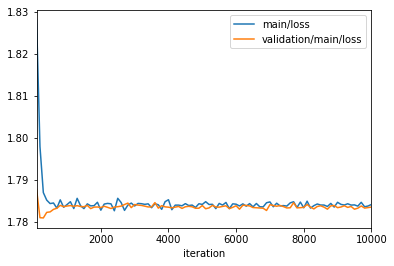

In [9]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

なんと学習が一歩も進みませんでしたね。これでは使い物になりません。（そしてこういったことは大変よくあることです。）

学習の初期段階で少しlossが下がりましたが、その後は横ばいになってしまいましたね。もし、lossが変わらないのがパラメータの変化が止まってしまった空であると仮定すると、その理由は勾配が消失したと考えるのが妥当でしょう。従って、アクティベーション関数を、勾配が消失しないreluに切り替えてみましょう。

In [10]:
class ModelReLu(Chain):
    def __init__(self):
        super(ModelReLu, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(561, 200)
            self.l2 = L.Linear(200, 100)
            self.l3 = L.Linear(100, 70)
            self.l4 = L.Linear(70, 50)
            self.l5 = L.Linear(50, 30)
            self.l6 = L.Linear(30, 20)
            self.l7 = L.Linear(20, 10)
            self.l8 = L.Linear(10, 6)
    
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = F.relu(self.l3(h))
        h = F.relu(self.l4(h))
        h = F.relu(self.l5(h))
        h = F.relu(self.l6(h))
        h = F.relu(self.l7(h))
        return self.l8(h)

In [11]:
model = ModelReLu()
classifier = L.Classifier(model)
optimizer = SGD()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (10000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100, 'iteration'))
trainer.extend(PrintReport(['iteration', "main/loss", "validation/main/loss"]))

logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   validation/main/loss
100         1.76932     1.72069               
200         1.60971     1.37849               
300         1.18694     0.949245              
400         0.842584    0.697973              
500         0.574195    0.441145              
600         0.375721    0.280488              
700         0.245133    0.236545              
800         0.181014    0.138029              
900         0.143047    0.130265              
1000        0.11306     0.0996587             
1100        0.0882865   0.19565               
1200        0.0943835   0.120573              
1300        0.0699356   0.0785371             
1400        0.0656718   0.0765875             
1500        0.0679164   0.0806214             
1600        0.0569625   0.0754222             
1700        0.058968    0.0690418             
1800        0.0405857   0.0902837             
1900        0.0363052   0.0692604             
2000        0.0432907   0.0714142             
2100        0.0

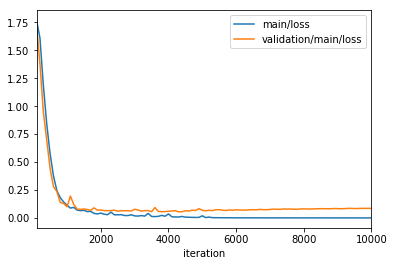

In [12]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

無事、うまく学習できましたが、よく見ると開発データに対するlossの値が反復のたびに悪化してしまっています。これでは未知のデータに対応できません。

この現象をなんと言ったか覚えていますか？

そう、過学習(overfitting)ですね。モデルが学習データに対して過度にチューニングされてしまうことにより、未知のデータに対しておかしな結果を返してしまう現象です。

## Dropout

さあ、いよいよこの章の本題です。学習データに対するlossの値は順調に下がりましたが、開発データに対するlossが悪化してしまいました。こういった過学習に抗う手段はいくつか提案されていますが、その中で最もシンプル・簡単かつ強力な方法がDropoutです。

chainerではこのDropoutもFunctionとして用意されています。手法の詳細は後で解説しますのでとりあえず使ってみましょう。

In [13]:
class ModelDropout(Chain):
    def __init__(self):
        super(ModelDropout, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(561, 200)
            self.l2 = L.Linear(200, 100)
            self.l3 = L.Linear(100, 70)
            self.l4 = L.Linear(70, 50)
            self.l5 = L.Linear(50, 30)
            self.l6 = L.Linear(30, 20)
            self.l7 = L.Linear(20, 10)
            self.l8 = L.Linear(10, 6)
    
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.dropout(h, ratio=0.3)
        h = F.relu(self.l2(h))
        h = F.dropout(h, ratio=0.3)
        h = F.relu(self.l3(h))
        h = F.dropout(h, ratio=0.3)
        h = F.relu(self.l4(h))
        h = F.dropout(h, ratio=0.3)
        h = F.relu(self.l5(h))
        h = F.dropout(h, ratio=0.3)
        h = F.relu(self.l6(h))
        h = F.dropout(h, ratio=0.3)
        h = F.relu(self.l7(h))
        h = F.dropout(h, ratio=0.3)
        return self.l8(h)

使い方は簡単で、層の間にdropoutを挟み込むだけです。

In [14]:
model = ModelDropout()
classifier = L.Classifier(model)
optimizer = SGD()
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (10000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100, 'iteration'))
trainer.extend(PrintReport(['iteration', "main/loss", "validation/main/loss"]))

logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   validation/main/loss
100         1.80135     1.77291               
200         1.78137     1.75421               
300         1.75579     1.70157               
400         1.7096      1.60149               
500         1.63546     1.48791               
600         1.57356     1.42183               
700         1.52078     1.37633               
800         1.46498     1.33846               
900         1.41779     1.31382               
1000        1.37773     1.29191               
1100        1.34059     1.26728               
1200        1.31606     1.24686               
1300        1.28751     1.22207               
1400        1.25609     1.19122               
1500        1.22993     1.15619               
1600        1.20707     1.08632               
1700        1.17099     1.03609               
1800        1.14674     0.997496              
1900        1.12733     0.962699              
2000        1.09613     0.936839              
2100        1.0

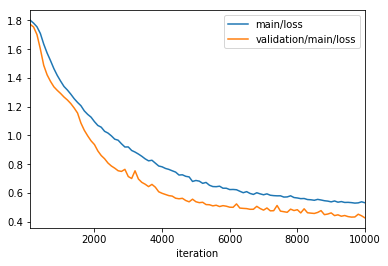

In [15]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

相当収束が遅くなってしまいましたね。これではDropoutの効果がよくわかりません。

今はSGDを使っていますが、安定して早く収束すると言われているAdamに切り替えてみましょう。

In [16]:
from chainer.optimizers import Adam

In [17]:
model = ModelDropout()
classifier = L.Classifier(model)
optimizer = Adam() # <- ここをAdamに変えた
optimizer.setup(classifier)
updater = StandardUpdater(train_iterator, optimizer, loss_func=classifier)
trainer = Trainer(updater, (10000, 'iteration'))
trainer.extend(Evaluator(dev_iterator, classifier), trigger=(100, 'iteration'))
trainer.extend(PrintReport(['iteration', "main/loss", "validation/main/loss"]))

logreport = LogReport(trigger=(100, 'iteration'))
trainer.extend(logreport)
trainer.run()

iteration   main/loss   validation/main/loss
100         1.60295     0.993365              
200         1.10038     0.491401              
300         0.815218    0.255879              
400         0.63101     0.205319              
500         0.52827     0.162381              
600         0.443264    0.136715              
700         0.401806    0.121699              
800         0.385269    0.106774              
900         0.358603    0.109477              
1000        0.326567    0.189539              
1100        0.307725    0.0855848             
1200        0.293865    0.085624              
1300        0.271067    0.0918318             
1400        0.243285    0.0974879             
1500        0.254879    0.0923003             
1600        0.225764    0.0720237             
1700        0.207589    0.0735655             
1800        0.206147    0.0855495             
1900        0.233777    0.145712              
2000        0.25205     0.265792              
2100        0.2

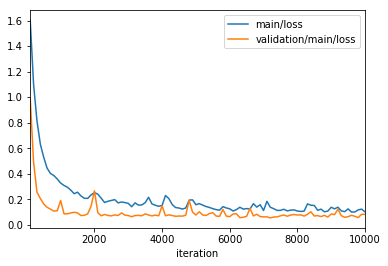

In [18]:
log_df = pd.DataFrame(logreport.log)
pd.DataFrame(log_df[["main/loss", "validation/main/loss"]].values, columns=["main/loss", "validation/main/loss"], index=log_df["iteration"]).plot()

学習データのlossが収束しても、開発データのlossが悪化していません。これがDropoutの効果です。

## Dropoutは何をしているのか

Dropoutの威力についてはご理解頂けたかと思います。それではDropoutとは何をしているのでしょうか？実際に動かして見てみましょう。

In [19]:
x = np.random.random(10).reshape((1,10)).astype(np.float32)

In [20]:
x

array([[  9.11708176e-01,   9.63724032e-02,   6.12630160e-04,
          6.68169975e-01,   8.09404731e-01,   1.88800380e-01,
          3.11954021e-02,   3.40308934e-01,   3.80505174e-01,
          2.84421183e-02]], dtype=float32)

In [21]:
F.dropout(x, ratio=0.5)

variable([[  1.82341635e+00,   1.92744806e-01,   1.22526032e-03,
             1.33633995e+00,   1.61880946e+00,   0.00000000e+00,
             6.23908043e-02,   6.80617869e-01,   7.61010349e-01,
             5.68842366e-02]])

10個の入力のうち、5個が0になっていますね！これがDropoutのアイディアです。ratioとは何でしょうか。試しに0をセットしてみましょう。

In [22]:
F.dropout(x, ratio=0)

variable([[  9.11708176e-01,   9.63724032e-02,   6.12630160e-04,
             6.68169975e-01,   8.09404731e-01,   1.88800380e-01,
             3.11954021e-02,   3.40308934e-01,   3.80505174e-01,
             2.84421183e-02]])

何も変わりません。

実はDropoutとは、入力値の一部を強制的に0に置き換える処理のことを言います。ratioとは置き換える数の割合です。

0にならなかった部分の値が変わってしまっているのが気になるかもしれませんが、これは値の総量ができるだけ変わらないように全体に$1 / (1-\mathrm{ratio})$だけ補正がかけられた結果です。

驚くほどシンプルですよね。

## Dropoutの性質

Dropoutの性質として、3つ知っておいて頂きたいことがあります。

* 上記の実験でも出てきたように、Dropoutを使うと学習の収束が遅くなるという問題があります。今回はその問題を解決するため、optimizerとしてAdamを使いました。
* ratioの値を小さくすると収束が早くなり、大きくすると収束が遅くなります。
* ほとんどの場合、ratio=0.5のとき、ほぼ最高性能となります。

3つ目の、ratio=0.5のとき最高性能となる理由については様々な研究があります。その中でもわかりやすいのは、「Dropoutは、ratio=0.5のときRidge正則化が行われていると解釈できる」というものです。詳細については https://arxiv.org/pdf/1307.1493.pdf をご覧ください。(この論文は難しいです)

# 演習

「ratioの値を小さくすると収束が早くなり、大きくすると収束が遅くな」ることを実験で確認してください。

# 参考資料

https://arxiv.org/pdf/1307.1493.pdf